In [1]:
import torch
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
torch.cuda.is_available()

True

In [12]:
stockprices_df = pl.read_parquet("../data/stock_prices/**/*.parquet")

In [13]:
stockprices_df.head()

Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Brand_Name,Industry_Tag,Country,Ticker
"datetime[μs, UTC]",f64,f64,f64,f64,f64,f64,f64,str,str,str,str
2023-09-20 04:00:00 UTC,179.259995,179.699997,175.399994,175.490005,5.84362e7,0.0,0.0,"""apple""","""technology""","""usa""","""AAPL"""
2023-09-19 04:00:00 UTC,177.520004,179.630005,177.130005,179.070007,5.18269e7,0.0,0.0,"""apple""","""technology""","""usa""","""AAPL"""
2023-09-18 04:00:00 UTC,176.479996,179.380005,176.169998,177.970001,6.72576e7,0.0,0.0,"""apple""","""technology""","""usa""","""AAPL"""
2023-09-15 04:00:00 UTC,176.479996,176.494995,173.820007,175.009995,1.09259461e8,0.0,0.0,"""apple""","""technology""","""usa""","""AAPL"""
2023-09-15 04:00:00 UTC,176.479996,176.5,173.820007,175.009995,1.092051e8,0.0,0.0,"""apple""","""technology""","""usa""","""AAPL"""


<Axes: xlabel='Date', ylabel='Close'>

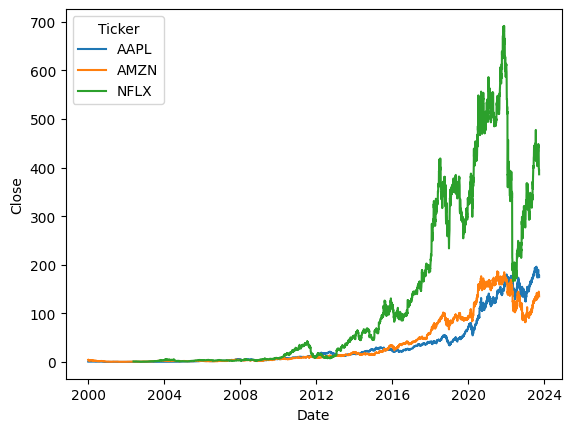

In [14]:
filtered_pdf = stockprices_df.filter(
    pl.col("Ticker").is_in(["AAPL", "AMZN", "NFLX"])
).to_pandas()

sns.lineplot(filtered_pdf, x="Date", y="Close", hue="Ticker")